# Soil map dataset

### In this notebook, we explore soil data from multiple perspectives to understand land characteristics in the Netherlands. We analyze how the land is used, look at soil types and regions using national soil maps, and investigate detailed soil profile information, including layers and horizons. Additionally, we consider the physical composition of soil, such as particle size distribution and characteristics of both top and bottom layers. 

In [86]:
import pandas
import geopandas
import xarray
from shapely import geometry
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import fiona
import osmnx
import rioxarray
import datashader
import contextily as cx
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.features import rasterize
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib.colors import ListedColormap
from matplotlib import cm
import os

### Type of the soil dataset

This dataset represents different land areas in the Netherlands, categorized by soil types and land use. Each row describes a specific region with attributes such as the name (LMM14naam), soil type (HGRnaam), surface area (Oppkm2 in square kilometers and OppHa in hectares), and geometry (MULTIPOLYGON) used for spatial mapping.

In [87]:
# load the data
current_dir = os.getcwd()
soil_type_path = os.path.join(current_dir, "data", "LMM14_HGR", "LMM14_HGR.shp")s

In [88]:
lmm = geopandas.read_file(soil_type_path)
print(lmm.columns)
lmm.head()

Index(['LMM14nr', 'LMM14naam', 'HGRnr', 'HGRnaam', 'Oppkm2', 'OppHa', 'groep',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')


,LMM14nr,LMM14naam,HGRnr,HGRnaam,Oppkm2,OppHa,groep,Shape_Leng,Shape_Area,geometry
0,1,Noordelijk Zeekleigebied,2,klei,2782,278155.0,Klei,6.914546e+05,2.781548e+09,"MULTIPOLYGON (((153749 565427, 153793 565364, ..."
1,2,Noordelijk Veenweidegeb.,3,veen,1657,165741.0,Veen,4.736756e+05,1.657414e+09,"MULTIPOLYGON (((184855 511154, 184892 511129, ..."
2,3,Polders en Droogmakerijen,2,klei,3422,342242.0,Klei,1.003352e+06,3.422415e+09,"MULTIPOLYGON (((92170.4 460493.696, 92437.4 46..."
3,4,Westelijk Veenweidegeb.,3,veen,1929,192919.0,Veen,7.014368e+05,1.929187e+09,"MULTIPOLYGON (((147852.2 476898.22, 147938.05 ..."
4,5,Zuidwestelijk Kleigebied,2,klei,3630,363042.0,Klei,1.638755e+06,3.630416e+09,"MULTIPOLYGON (((25134.069 381458.669, 25226.24..."


Display the soil types on the map

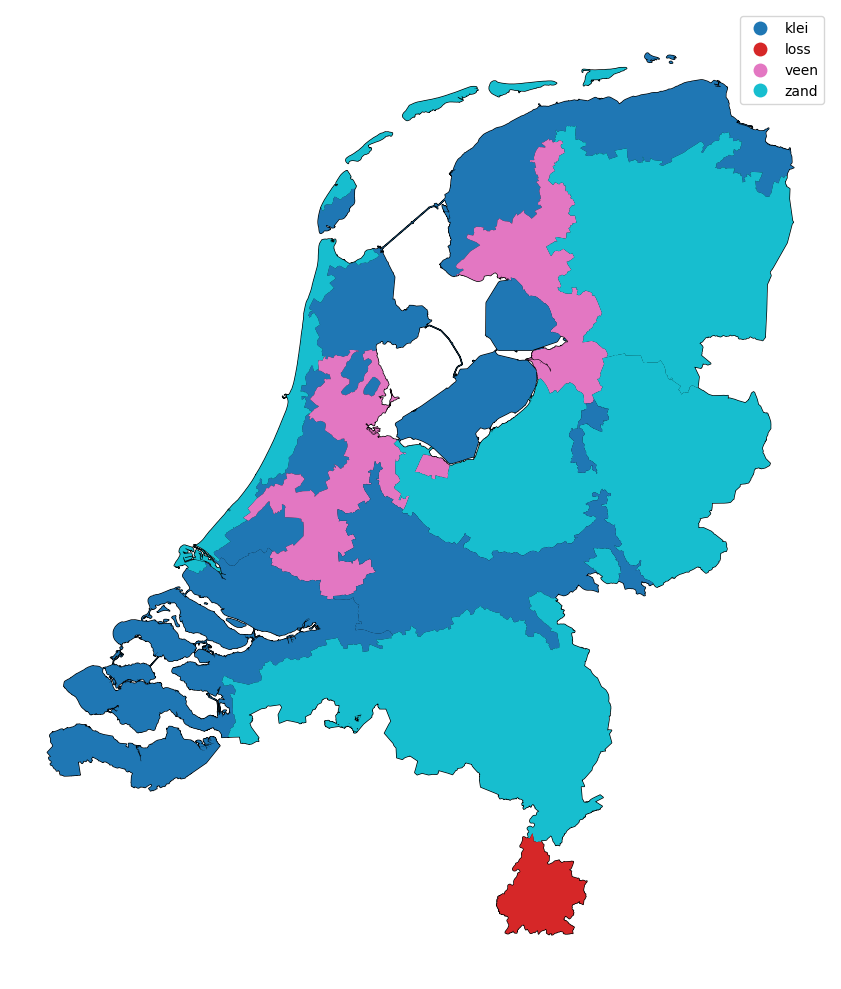

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))
lmm.plot(ax=ax, edgecolor='black', facecolor='lightgrey')

lmm.plot(column='HGRnaam', ax=ax, legend=True)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Land use dataset (surface data structure)

This dataset comes from https://lgn.nl/bestanden. It represents land use classification based on the LGN7 (Landelijk Grondgebruik Nederland) raster map of the Netherlands. Each pixel in the raster image corresponds to a specific land use type, coded with integer values from 0 to 62 (e.g., agricultural land, forest, water, urban areas).

In [90]:
# path to the data
current_dir = os.getcwd()
land_use_path = os.path.join(current_dir, "data", "LGN7_land_use", "LGN7.tif")

Below we see that this is a surface data structure with only one layer (band)

In [91]:
lgn = rioxarray.open_rasterio(land_use_path, masked=True)
print(lgn)

<xarray.DataArray (band: 1, y: 13000, x: 11200)> Size: 582MB
[145600000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 90kB 12.5 37.5 62.5 ... 2.799e+05 2.8e+05 2.8e+05
  * y            (y) float64 104kB 6.25e+05 6.25e+05 6.249e+05 ... 3e+05 3e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:  GRASS GIS 7.8.2 with GDAL 3.0.4
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0


In [92]:
# checking some basic characteristics of the dataset, like shape, Common Reporting Standard (CRS), and land codes.
print("Raster size:", lgn.shape)
print("CRS:", meta["crs"])
print("Unique land use codes:", np.unique(lgn))

Raster size: (1, 13000, 11200)
CRS: EPSG:28992
Unique land use codes: [ 1.  2.  3.  4.  5.  6.  8.  9. 10. 11. 12. 16. 17. 18. 19. 20. 22. 23.
 24. 25. 26. 28. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43.
 45. 61. 62. nan]


Display land use on the map

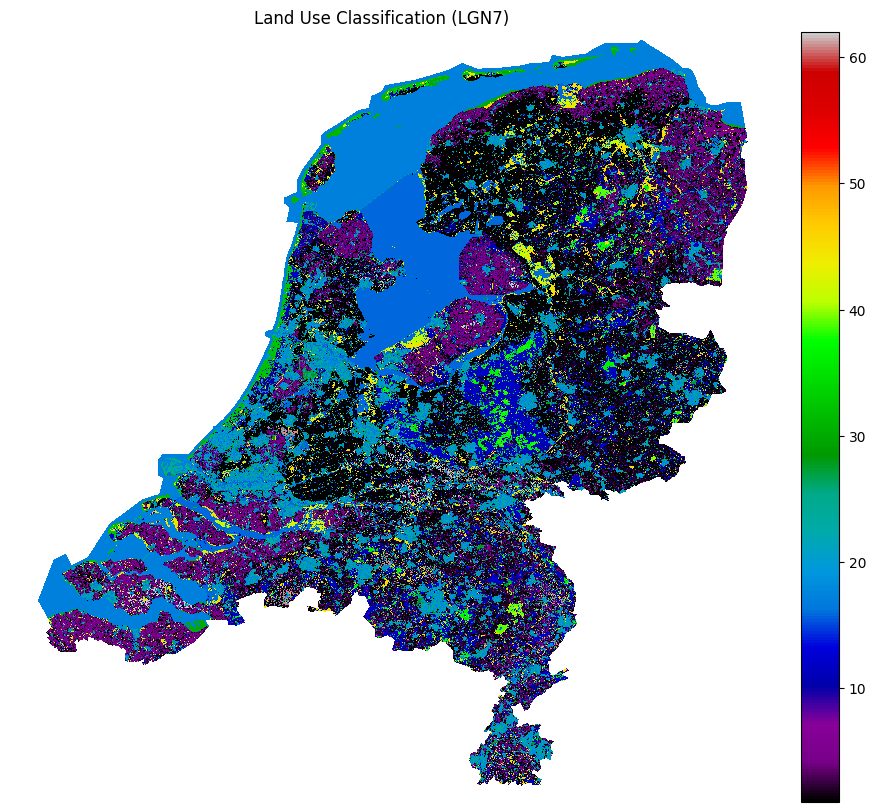

In [93]:
lgn.plot(cmap="nipy_spectral", figsize=(12, 10))
plt.title("Land Use Classification (LGN7)")
plt.axis("off")
plt.show()

## Soil map dataset

This dataset is a multi-layered soil database that includes pedological properties and land characteristics.

Data source: https://bodemdata.nl/downloads

In [94]:
# path to the data
current_dir = os.getcwd()
soil_physical_properties_path = os.path.join(current_dir, "data", "Wageningen_soil_map", "BRO-SGM-DownloadBodemkaart-V2024-01_1.gpkg")

In [95]:
# tables of the database
fiona.listlayers(soil_physical_properties_path)

['areaofpedologicalinterest',
 'soilarea',
 'nga_properties',
 'soilmap',
 'normalsoilprofiles',
 'normalsoilprofiles_landuse',
 'soilhorizon',
 'soilhorizon_fractionparticlesize',
 'soillayer',
 'soil_units',
 'soilcharacteristics_bottomlayer',
 'soilcharacteristics_toplayer',
 'soilarea_normalsoilprofile',
 'soilarea_soilunit',
 'soilarea_soilunit_soilcharacteristicstoplayer',
 'soilarea_soilunit_soilcharacteristicsbottomlayer']

Load only relevant tables (layers) such as soil horizons, areas, land use, soil layers

In [96]:
# containts soil characteristics
horizon = geopandas.read_file(soil_physical_properties_path, layer="soilhorizon")

# a relationship between tables
profile_area = geopandas.read_file(soil_physical_properties_path, layer="soilarea_normalsoilprofile")

# table with Polygons
areas = geopandas.read_file(soil_physical_properties_path, layer="soilarea")

# table with land use
land_use = geopandas.read_file(soil_physical_properties_path, layer="normalsoilprofiles_landuse")

soil_layer = geopandas.read_file(soil_physical_properties_path, layer="soillayer")

/Users/Administrator/Documents/University/Year 3/2b/Thesis/spacial_env/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: Unexpected data type for record 1 in column validfrom
  return ogr_read(


Join tables to so for each Polygon we will have a correspoinding soil characteristics.

In [97]:
# join 'soilhorizon' with 'soilarea_normalsoilprofile'
horizon_profiles_area = horizon.merge(profile_area, on="normalsoilprofile_id")

# join to 'normalsoilprofiles_landuse'
horizon_profiles_area_landuse = horizon_profiles_area.merge(land_use,  on="normalsoilprofile_id")

area_geometry = areas[["maparea_id", "geometry"]]           # here we keep only necessary columns
horizon_with_geom = horizon_profiles_area_landuse.merge(area_geometry, on="maparea_id")

Convert resultant table into GeoDataFrame

In [98]:
soil_geo = geopandas.GeoDataFrame(horizon_with_geom, geometry="geometry")

Now we have all needed columns in one table.

In [99]:
print(soil_geo.columns)
soil_geo.shape

Index(['normalsoilprofile_id', 'layernumber', 'faohorizonnotation',
       'lowervalue', 'uppervalue', 'staringseriesblock',
       'organicmattercontent', 'minimumorganicmattercontent',
       'maximumorganicmattercontent', 'acidity', 'minimumacidity',
       'maximumacidity', 'cnratio', 'peattype', 'calciccontent', 'fedith',
       'loamcontent', 'minimumloamcontent', 'maximumloamcontent',
       'lutitecontent', 'minimumlutitecontent', 'maximumlutitecontent',
       'sandmedian', 'minimumsandmedian', 'maximumsandmedian', 'siltcontent',
       'density', 'inspireid', 'validfrom', 'beginlifespanversion',
       'maparea_id', 'landuse', 'geometry'],
      dtype='object')


(215640, 33)

The boundries of all Polygons (there are around 47000 polygons)

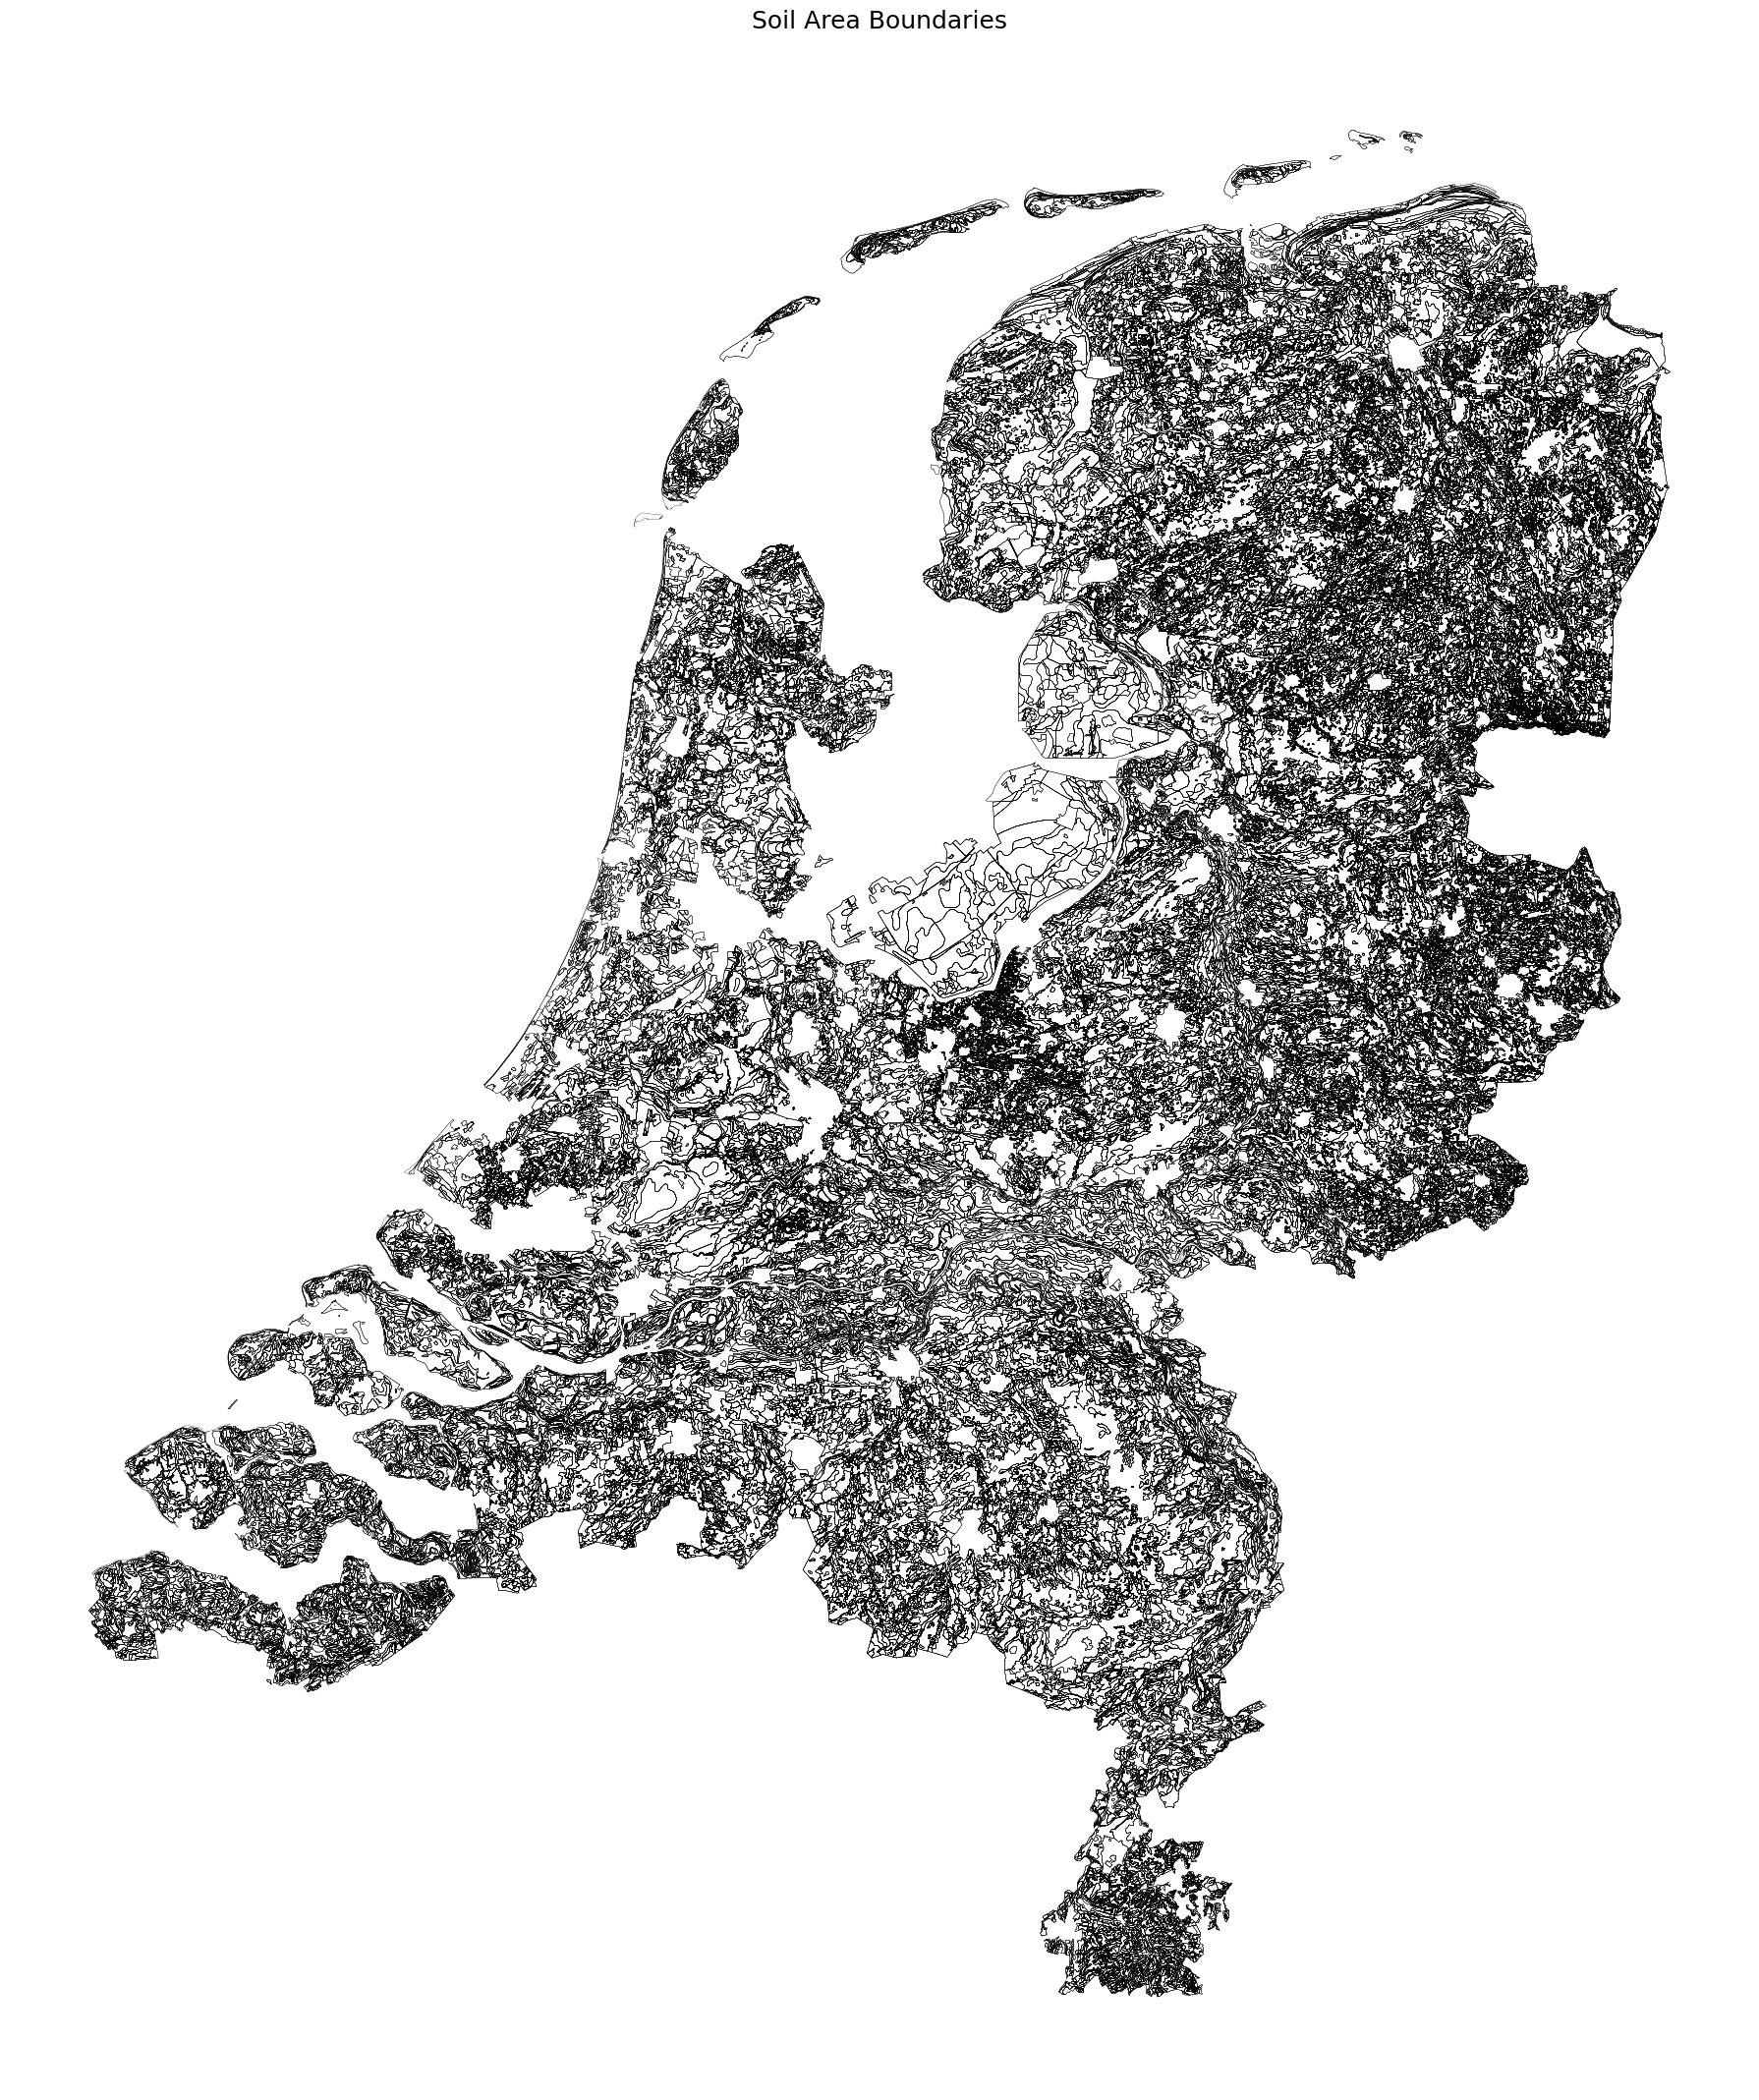

In [100]:
fig, ax = plt.subplots(figsize=(18, 24))

soil_geo.boundary.plot(ax=ax, linewidth=0.2, color="black")
ax.set_title("Soil Area Boundaries", fontsize=18)
ax.set_axis_off()

plt.tight_layout()
plt.show()

Display on map different layers. For visual purposes the 'organic matter' is chosen.

<Axes: >

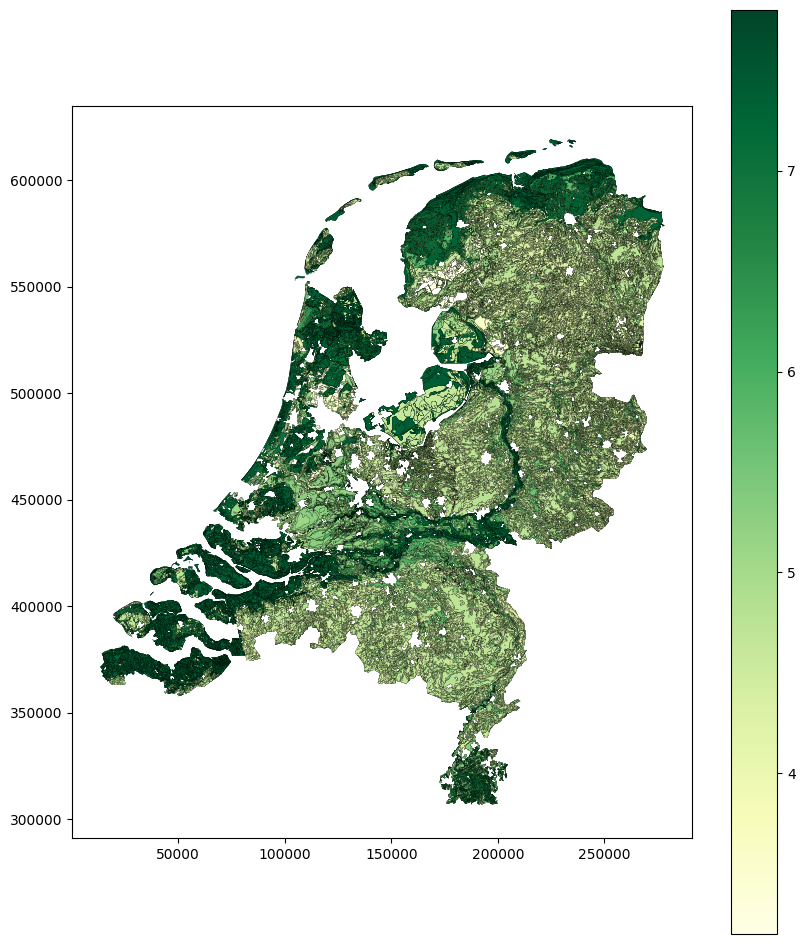

In [146]:
soil_geo_valid = soil_geo[soil_geo["organicmattercontent"].notna()]

soil_geo_valid.plot(
    column="acidity",
    cmap="YlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    figsize=(10, 12)
)

General information about each variable in the table

In [78]:
soil_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 215640 entries, 0 to 215639
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   normalsoilprofile_id         215640 non-null  int64         
 1   layernumber                  215640 non-null  int64         
 2   faohorizonnotation           215640 non-null  object        
 3   lowervalue                   215640 non-null  float32       
 4   uppervalue                   215640 non-null  float32       
 5   staringseriesblock           215640 non-null  int64         
 6   organicmattercontent         215640 non-null  float32       
 7   minimumorganicmattercontent  215640 non-null  float32       
 8   maximumorganicmattercontent  215640 non-null  float32       
 9   acidity                      215640 non-null  float32       
 10  minimumacidity               215640 non-null  float32       
 11  maximumacidity    

Range of each variable

In [81]:
soil_geo.describe()

,normalsoilprofile_id,layernumber,lowervalue,uppervalue,staringseriesblock,organicmattercontent,minimumorganicmattercontent,maximumorganicmattercontent,acidity,minimumacidity,...,lutitecontent,minimumlutitecontent,maximumlutitecontent,sandmedian,minimumsandmedian,maximumsandmedian,siltcontent,density,validfrom,beginlifespanversion
count,2.156400e+05,215640.000000,215640.000000,215640.000000,215640.000000,215640.000000,215640.000000,215640.000000,215640.000000,215640.000000,...,215640.000000,215640.000000,215640.000000,215640.000000,215640.000000,215640.000000,215640.000000,215640.000000,0,0
mean,1.429324e+07,2.782026,0.360862,0.635492,173.228937,9.004340,5.380112,13.139223,5.110847,4.651786,...,12.277449,7.974369,18.424912,142.790322,120.398697,173.587553,20.712669,1.342015,NaT,NaT
min,1.010000e+03,1.000000,0.000000,0.050000,101.000000,0.200000,0.100000,0.500000,3.200000,2.900000,...,1.000000,1.000000,4.000000,70.000000,60.000000,90.000000,1.000000,0.167000,NaT,NaT
25%,4.040000e+03,2.000000,0.080000,0.250000,110.000000,0.600000,0.300000,2.000000,4.500000,4.000000,...,3.000000,2.000000,6.000000,125.000000,100.000000,150.000000,8.000000,1.330000,NaT,NaT
50%,1.029000e+04,3.000000,0.300000,0.600000,202.000000,2.000000,1.000000,5.000000,4.800000,4.500000,...,4.000000,3.000000,8.000000,150.000000,130.000000,180.000000,15.000000,1.446000,NaT,NaT
75%,9.024010e+06,4.000000,0.600000,1.050000,208.000000,5.000000,3.000000,10.000000,5.300000,4.800000,...,18.000000,10.000000,25.000000,160.000000,140.000000,180.000000,34.000000,1.601000,NaT,NaT
max,9.031003e+07,9.000000,1.100000,1.200000,218.000000,95.000000,75.000000,98.000000,7.800000,7.500000,...,68.000000,50.000000,80.000000,500.000000,200.000000,800.000000,81.000000,1.680000,NaT,NaT
std,3.078568e+07,1.393233,0.309634,0.389616,47.395336,19.761105,13.275514,23.002916,1.045650,1.052343,...,14.106943,10.019105,18.413254,37.887809,30.397178,54.931789,16.999535,0.395995,NaN,NaN


Check for missing values

In [82]:
soil_geo.isnull().sum().sort_values(ascending=False)

beginlifespanversion           215640
validfrom                      215640
peattype                       192057
normalsoilprofile_id                0
minimumsandmedian                   0
lutitecontent                       0
minimumlutitecontent                0
maximumlutitecontent                0
sandmedian                          0
siltcontent                         0
maximumsandmedian                   0
minimumloamcontent                  0
density                             0
inspireid                           0
maparea_id                          0
landuse                             0
maximumloamcontent                  0
loamcontent                         0
layernumber                         0
fedith                              0
calciccontent                       0
cnratio                             0
maximumacidity                      0
minimumacidity                      0
acidity                             0
maximumorganicmattercontent         0
minimumorgan

Distribution of horizon types

Below is an overview of the horizons for which we have the most information in the dataset.

FAO soil horizon notations — a standardized way to describe distinct soil layers. Capital letters indicate master horizons (like O -- Organic horizon or C -- Parent rock)

Text(0, 0.5, 'Count')

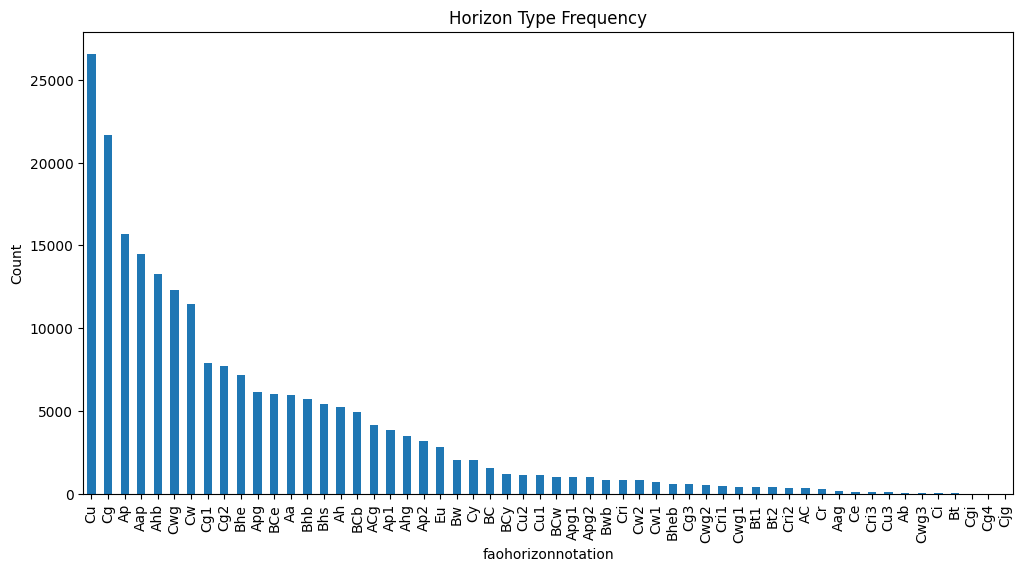

In [98]:
plt.figure(figsize=(12, 6)) 
soil_geo["faohorizonnotation"].value_counts().plot(kind="bar", title="Horizon Type Frequency")
plt.ylabel("Count")

Check the thickness of most of the layers in the soil

<Axes: xlabel='thickness', ylabel='Count'>

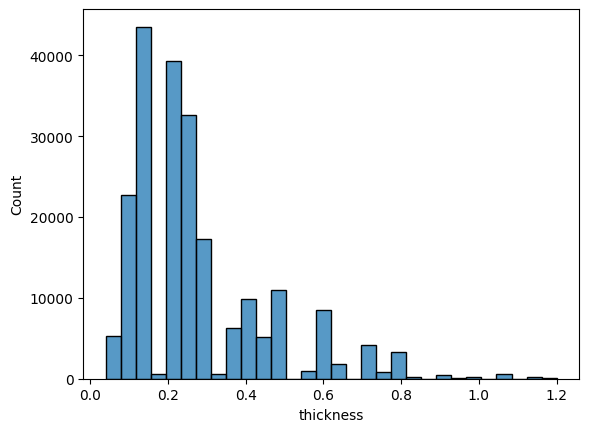

In [85]:
soil_geo["thickness"] = soil_geo["uppervalue"] - soil_geo["lowervalue"]
sns.histplot(soil_geo["thickness"], bins=30)

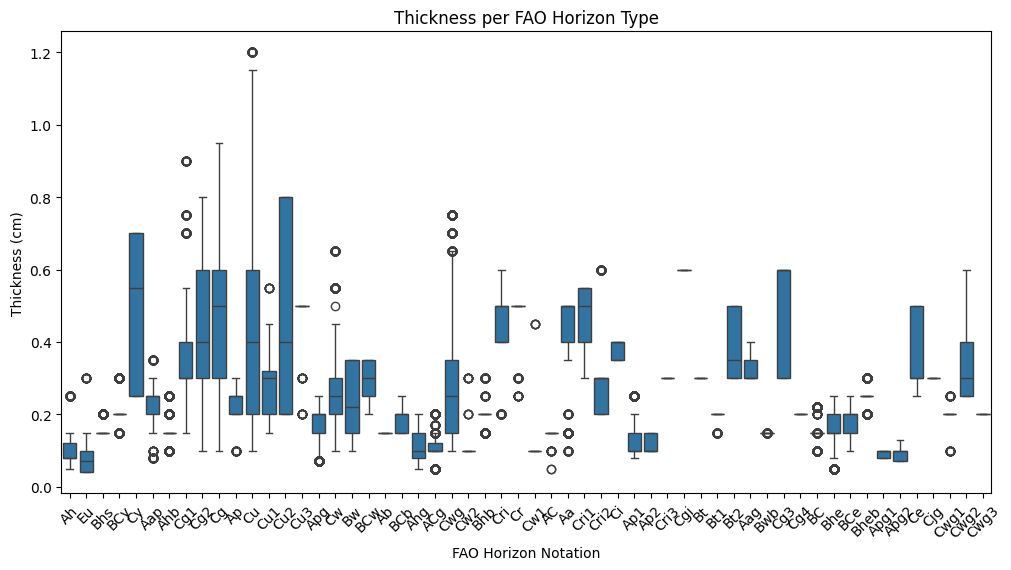

In [96]:
plt.figure(figsize=(12, 6)) 
sns.boxplot(data=soil_geo, x="faohorizonnotation", y="thickness")
plt.xticks(rotation=45)
plt.title("Thickness per FAO Horizon Type")
plt.ylabel("Thickness (cm)")
plt.xlabel("FAO Horizon Notation")
plt.show()

Soil composition variables

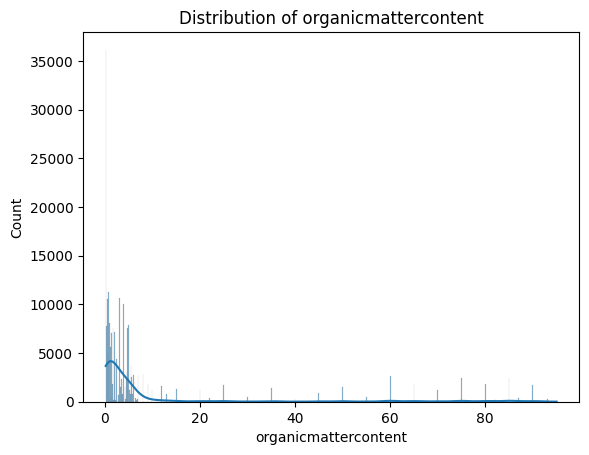

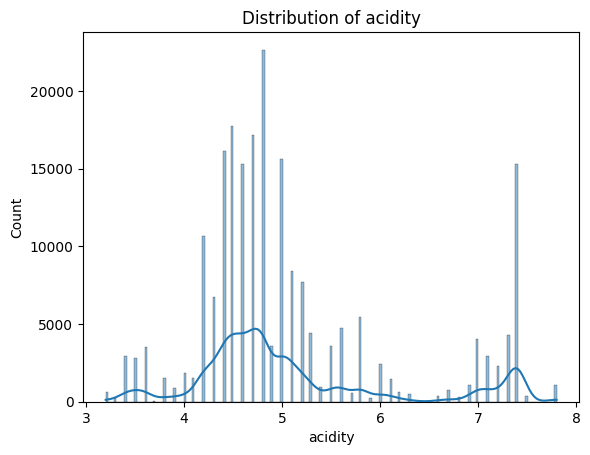

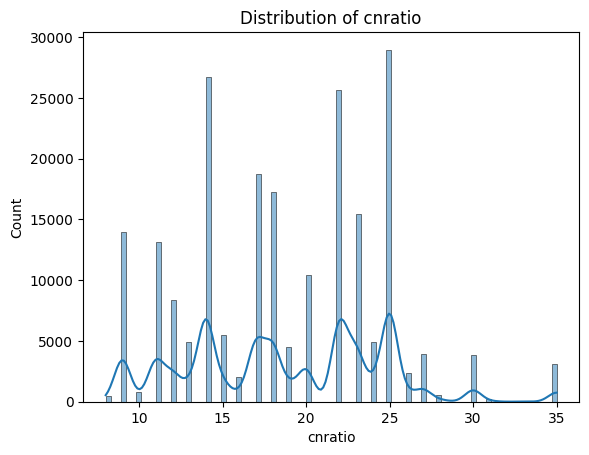

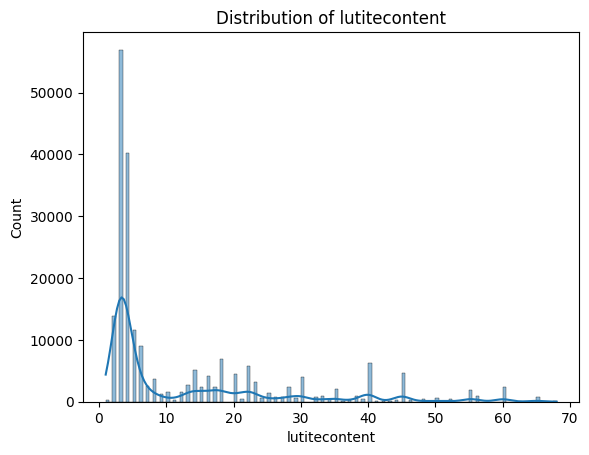

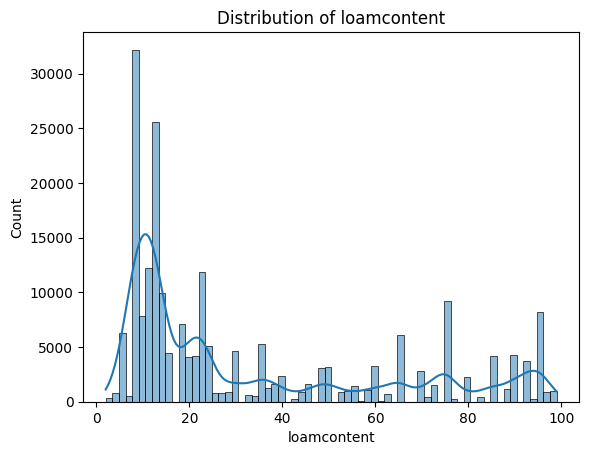

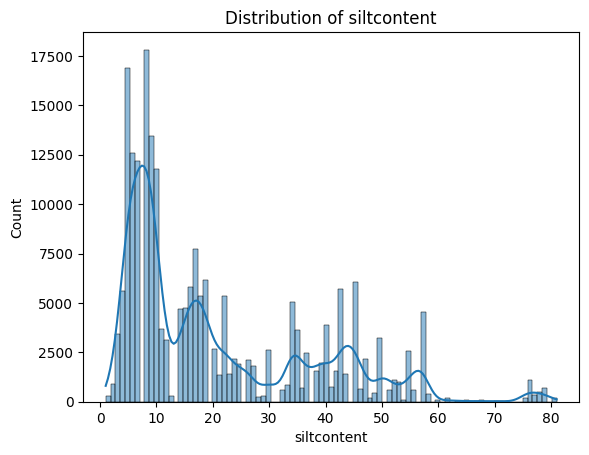

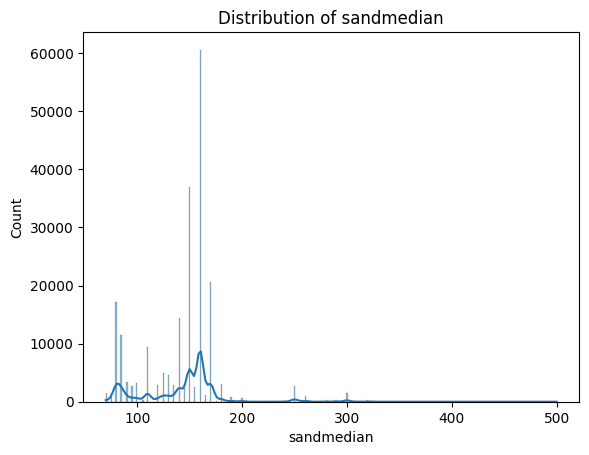

In [102]:
features = [
    "organicmattercontent", "acidity", "cnratio", "lutitecontent",
    "loamcontent", "siltcontent", "sandmedian"
]

for feature in features:
    sns.histplot(soil_geo[feature].dropna(), kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()